<a href="https://colab.research.google.com/github/ChangQingxgg/Document-Answering-Robot/blob/main/%E8%87%AA%E5%AE%9A%E4%B9%89%E8%AF%84%E4%BC%B0%E9%80%BB%E8%BE%91%E8%AF%84%E4%BC%B0%E5%9B%BD%E5%86%85%E5%A4%A7%E6%A8%A1%E5%9E%8B%EF%BC%88%E9%9D%9Eevidently%E7%89%88%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install openai
!pip install matplotlab

ERROR: Could not find a version that satisfies the requirement matplotlab (from versions: none)
ERROR: No matching distribution found for matplotlab


Mounted at /content/drive


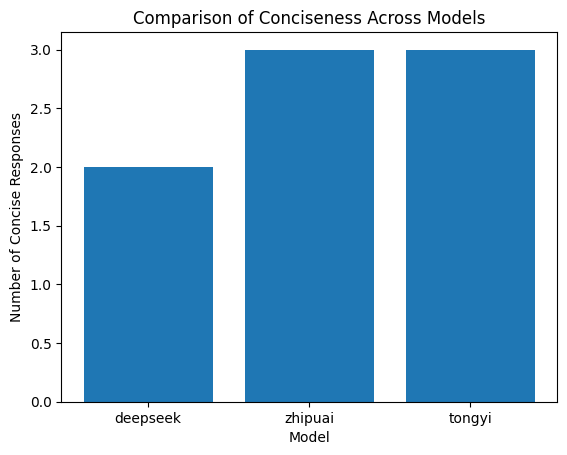

In [ ]:
import pandas as pd
import os
from openai import OpenAI
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Set DeepSeek API key
os.environ["DEEPSEEK_API_KEY"] = "sk-5bb4dcdbbbcb4d00a7a86c394b48f8cd"
client = OpenAI(api_key=os.getenv("DEEPSEEK_API_KEY"), base_url="https://api.deepseek.com")

# Load data
df = pd.read_csv("/content/drive/MyDrive/medical_responses_qwen.csv")

# Define evaluation prompt for conciseness
eval_prompt = """You are a judge evaluating the conciseness of text. Conciseness refers to the quality of being brief and to the point, while still providing all necessary information. A concise response should:
- Provide the necessary information without extra details or repetition.
- Be brief yet comprehensive enough to address the query.
- Use simple and direct language to convey the message effectively.

Evaluate the following response and classify it as "concise", "verbose", or "unknown". Also, provide a reasoning for your classification.

Response: {}

Classification:"""

# Function to evaluate conciseness
def evaluate_conciseness(response):
    try:
        completion = client.chat.completions.create(
            model="deepseek-reasoner",
            messages=[
                {"role": "system", "content": "You are a judge evaluating text."},
                {"role": "user", "content": eval_prompt.format(response)}
            ],
            max_tokens=500,
            temperature=0.7
        )
        return completion.choices[0].message.content
    except Exception as e:
        return f"Error: {e}"

# Evaluate responses for each model
results = {}
for model in ["deepseek", "zhipuai", "tongyi"]:
    responses = df[f"{model}_response"]
    evaluations = [evaluate_conciseness(r) for r in responses]
    results[model] = evaluations

# Add evaluation results to DataFrame
for model in results:
    df[f"{model}_conciseness"] = results[model]

# Save results
df.to_csv("/content/drive/MyDrive/evaluated_medical_responses.csv", index=False)

# Count "concise" responses for visualization
concise_counts = {}
for model in ["deepseek", "zhipuai", "tongyi"]:
    concise_counts[model] = sum("concise" in eval.lower() for eval in results[model])

# Visualize results with a bar chart
plt.bar(concise_counts.keys(), concise_counts.values())
plt.xlabel("Model")
plt.ylabel("Number of Concise Responses")
plt.title("Comparison of Conciseness Across Models")
plt.savefig('/content/drive/MyDrive/conciseness_comparison.png')